In [21]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')






In [3]:
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


In [4]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [5]:
'''Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. 
Тем самым переходим от данных по регионам к данным по странам:'''

covid_data = covid_data.groupby(
    ['date', 'country'],
    as_index = False
)[['confirmed', 'deaths', 'recovered']].sum()
display(covid_data)

,date,country,confirmed,deaths,recovered
0,01/01/2021,Afghanistan,51526.0,2191.0,41727.0
1,01/01/2021,Albania,58316.0,1181.0,33634.0
2,01/01/2021,Algeria,99897.0,2762.0,67395.0
3,01/01/2021,Andorra,8117.0,84.0,7463.0
4,01/01/2021,Angola,17568.0,405.0,11146.0
...,...,...,...,...,...
86780,12/31/2020,Vietnam,1465.0,35.0,1325.0
86781,12/31/2020,West Bank and Gaza,138004.0,1400.0,117183.0
86782,12/31/2020,Yemen,2099.0,610.0,1394.0
86783,12/31/2020,Zambia,20725.0,388.0,18660.0


In [6]:
'''Преобразуем даты в формат datetime с помощью функции pd.to_datetime():'''

covid_data['date'] = pd.to_datetime(covid_data['date'])

In [7]:
'''Создадим признак больных на данный момент (active). 
Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:'''

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

In [8]:
'''Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
Для этого отсортируем данные по названиям стран, а затем по датам. 
После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():'''

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

display(covid_data.head())

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
'''В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:'''

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [10]:
display(covid_data['date'])
print(covid_data['date'].min())
print(covid_data['date'].max())

11337   2020-02-24
11570   2020-02-25
11807   2020-02-26
12051   2020-02-27
12299   2020-02-28
           ...    
15933   2020-03-12
16595   2020-03-14
16938   2020-03-15
17290   2020-03-16
17645   2020-03-17
Name: date, Length: 86785, dtype: datetime64[ns]

2020-01-22 00:00:00
2021-05-29 00:00:00


In [11]:
print(vaccinations_data['date'].min())
print(vaccinations_data['date'].max())

2020-12-02 00:00:00
2021-09-06 00:00:00


In [12]:
covid_df = covid_data.merge(
    vaccinations_data,
    on = ['date', 'country'],
    how = 'left'
)
#covid_df.info()

In [13]:
covid_df['death_rate'] = (covid_df['deaths'] / covid_df['confirmed']) * 100
covid_df['recover_rate'] = (covid_df['recovered'] / covid_df['confirmed']) * 100

round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(), 2)
round(covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean(), 2)

67.06

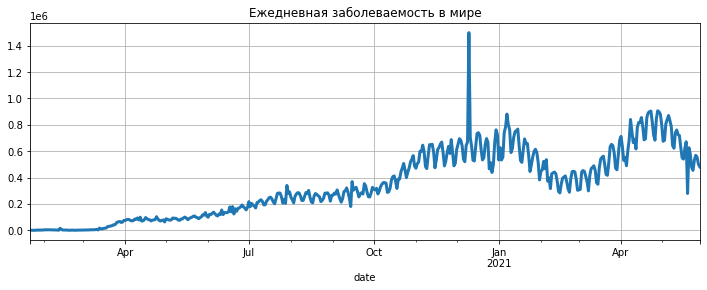

In [14]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind = 'line',
    figsize = (12,4),
    title = 'Ежедневная заболеваемость в мире',
    grid = True,
    lw = 3
);

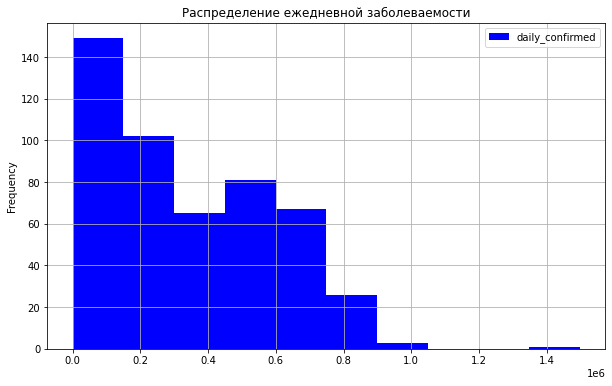

In [15]:
grouped_cases.plot(
    kind = 'hist',
    figsize = (10,6),
    title ='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'blue',
    legend = True,
    bins = 10
);

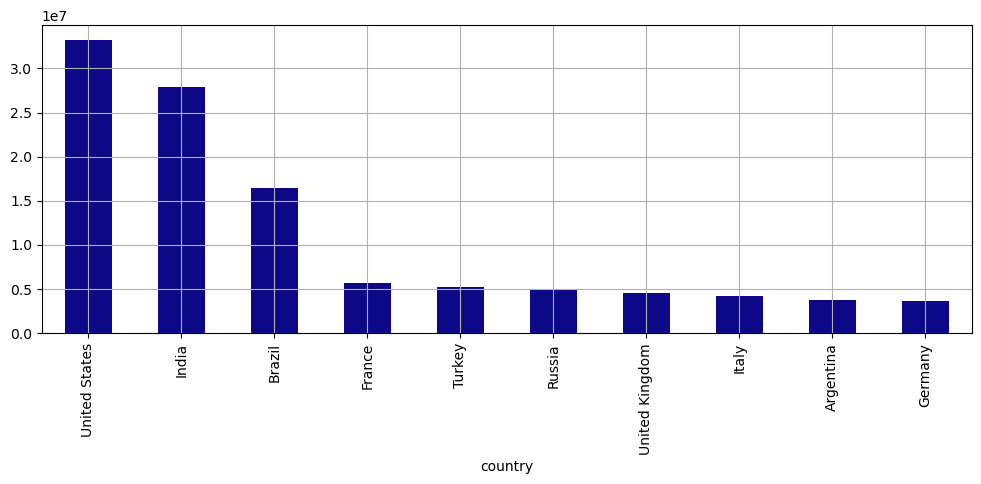

In [24]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind = 'bar',
    grid = True,
    figsize = (12,4),
    colormap = 'plasma'
);

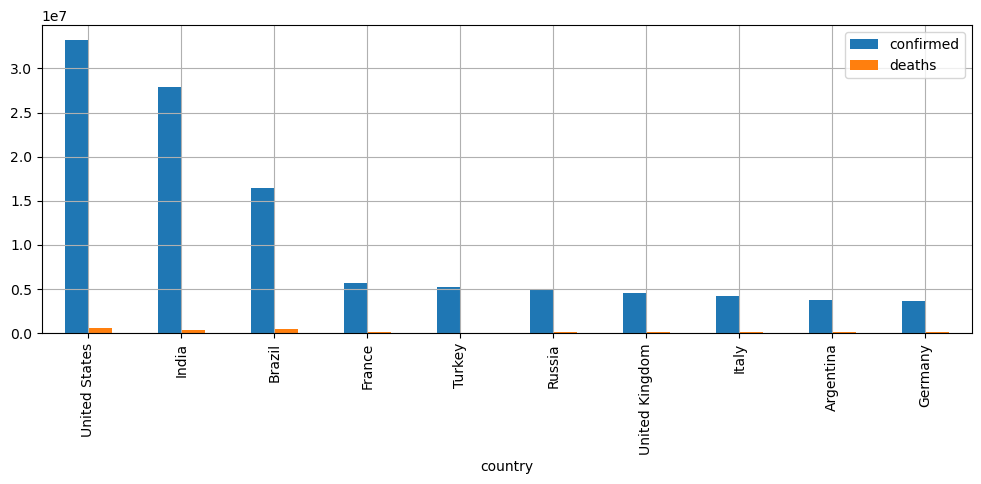

In [22]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(
    kind = 'bar',
    grid = True,
    figsize = (12,4)
);

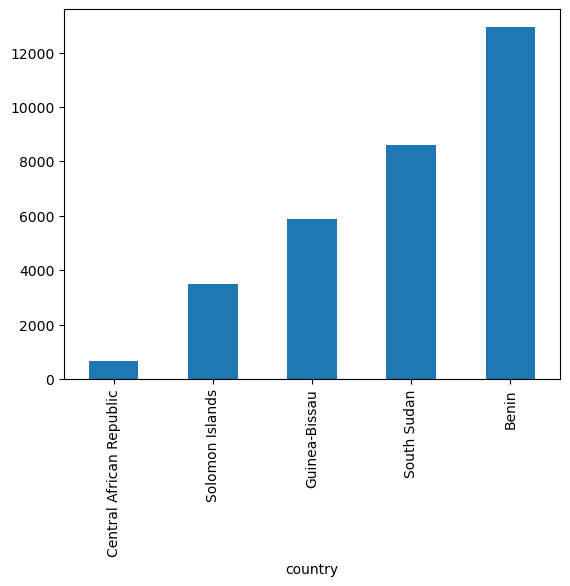

In [23]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');